In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
#from xgboost.sklearn import XGBClassifier
from xgboost import XGBClassifier
# from sklearn import cross_validation, metrics
# from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics

from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

from numpy import sort
from sklearn.feature_selection import SelectFromModel

# # Ignore warnings
# import warnings
# warnings.simplefilter('ignore')

In [6]:
# Import the train set and test set
#train_data2 = pd.read_csv("trainset.csv", delimiter=",")
#test_data2 = pd.read_csv("testset.csv", delimiter=",")

train = pd.read_csv("normalized_train_dataset.csv", delimiter=",")
test = pd.read_csv("normalized_test_dataset.csv", delimiter=",")

In [7]:
train.shape, test.shape

((9567, 36), (3190, 35))

In [8]:
target = 'Product'
IDcol = 'ID'

In [9]:
#test_results = pd.read_csv('test_results.csv')
def modelfit2(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    # fit model on training data
    model = alg
    
    X_train, X_test, y_train, y_test = train_test_split(dtrain[predictors], dtrain[target], test_size=0.33, random_state=7)
    eval_set = [(X_test, y_test)]
    model.fit(X_train,
              y_train,
              early_stopping_rounds=early_stopping_rounds,
              eval_metric="merror",
              eval_set=eval_set,
              verbose=False)
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    
    print("f1_micro: %.2f%%" % (f1_score(y_test, predictions, average='micro') * 100.0))
    print("f1_macro: %.2f%%" % (f1_score(y_test, predictions, average='macro') * 100.0))
    print("f1_weighted: %.2f%%" % (f1_score(y_test, predictions, average='weighted') * 100.0))
    print("f1_none: %.2f%%" % (f1_score(y_test, predictions, average='none') * 100.0))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
#         xgtest = xgb.DMatrix(dtest[predictors].values)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='merror',
#                           early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult.shape[0])
    
#     #Fit the algorithm on the data
#     alg.fit(dtrain[predictors], dtrain['Product'],eval_metric='auc')
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
#     #Print model report:
#     print("\nModel Report")
#     print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Product'].values, dtrain_predictions))
#     #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Product'], dtrain_predprob))
    
# #     Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    results = test_results.merge(dtest[['ID','predprob']], on='ID')
    #print(dtest[['ID','predprob']])
#     #print('AUC Score (Test): %f' % metrics.roc_auc_score(results['Product'], results['predprob']))
        
    #feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

    plot_importance(model)
    plt.show()
    print("Model: " + str(model))
    thresholds = alg.feature_importances_
    print("Feature_Importances: ")
    print(dtrain.columns[thresholds.argsort()[-10:][::-1]])

In [10]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['merror', 'mlogloss'], early_stopping_rounds=early_stopping_rounds, 
                          verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(cvresult)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Product'],eval_metric='merror')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Product'].values, dtrain_predictions))
    print("f1_micro : %.4g" % metrics.f1_score(dtrain['Product'], dtrain_predictions, average='micro'))
    print("f1_macro : %.4g" % metrics.f1_score(dtrain['Product'], dtrain_predictions, average='macro'))
    print("f1_weighted : %.4g" % metrics.f1_score(dtrain['Product'], dtrain_predictions, average='weighted'))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')
    plot_importance(alg)
    plt.show()
    thresholds = alg.feature_importances_
    print("Feature_Importances: ")
    print(dtrain.columns[thresholds.argsort()[-10:][::-1]])
    print("Model: " + str(alg.get_xgb_params()))
    print("n_estimator: " + str(cvresult.shape[0]))
    return cvresult.shape[0]

In [11]:
def important_features(model, nfeatures = 10):
    model.fit()
    thresholds = model.feature_importances_
    
    return train.column[thresholds.argsort()[-nfeatures:][::-1]]

# Step 1- Find the number of estimators for a high learning rate

In [12]:
train.columns

Index(['ID', 'DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlySMSTrafficCount', 'MonthlyDataTraffic', 'CustomerGender',
       'CustomerExpatriate', 'ZipCode', 'ChurnScore',
       'AirportConnectionsDuration', 'AirportConnectionsCount',
       'StationConnectionsDuration', 'StationConnectionsCount',
       'ParkingConnectionsDuration', 'ParkingConnectionsCount',
       'File-Transfer', 'Games', 'Instant-Messaging-Applications', 'Mail',
       'Music-Streaming', 'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications', 'IsModified', 'CustomerAge', 'Region', 'Province',
       'Product'],
      dtype='object')

[0]	train-merror:0.403104+0.00532332	train-mlogloss:1.33398+0.000517456	test-merror:0.409011+0.00561087	test-mlogloss:1.33563+0.000765435
[1]	train-merror:0.404149+0.00310737	train-mlogloss:1.29015+0.000697201	test-merror:0.410473+0.00762171	test-mlogloss:1.29329+0.00166461
[2]	train-merror:0.402556+0.00438792	train-mlogloss:1.25268+0.000735809	test-merror:0.409427+0.0100197	test-mlogloss:1.25724+0.00287303
[3]	train-merror:0.397408+0.00420617	train-mlogloss:1.22044+0.000852628	test-merror:0.406396+0.00709593	test-mlogloss:1.22608+0.00401474
[4]	train-merror:0.394743+0.000475294	train-mlogloss:1.19199+0.00056898	test-merror:0.403782+0.00821374	test-mlogloss:1.19871+0.00464697
[5]	train-merror:0.394638+0.000306836	train-mlogloss:1.16721+0.000887155	test-merror:0.403887+0.00799078	test-mlogloss:1.17501+0.00517947
[6]	train-merror:0.393723+0.000716871	train-mlogloss:1.14559+0.000907642	test-merror:0.402842+0.00797429	test-mlogloss:1.1546+0.00549511
[7]	train-merror:0.392652+0.00109132	tra

[60]	train-merror:0.360589+0.00183269	train-mlogloss:0.905832+0.00311907	test-merror:0.390195+0.00469605	test-mlogloss:0.971479+0.00926869
[61]	train-merror:0.359752+0.00156357	train-mlogloss:0.904421+0.00313528	test-merror:0.389568+0.00443475	test-mlogloss:0.971035+0.00940552
[62]	train-merror:0.359543+0.0015399	train-mlogloss:0.90297+0.0030571	test-merror:0.390091+0.00456101	test-mlogloss:0.970306+0.00943098
[63]	train-merror:0.358707+0.00198879	train-mlogloss:0.901659+0.00314396	test-merror:0.389568+0.00409727	test-mlogloss:0.969676+0.00955799
[64]	train-merror:0.357871+0.00203593	train-mlogloss:0.90034+0.00310811	test-merror:0.39009+0.00436331	test-mlogloss:0.969478+0.00975543
[65]	train-merror:0.357453+0.00184133	train-mlogloss:0.899019+0.00318176	test-merror:0.389986+0.00473112	test-mlogloss:0.96884+0.00979215
[66]	train-merror:0.357035+0.00192061	train-mlogloss:0.897626+0.00316179	test-merror:0.389776+0.00610327	test-mlogloss:0.968359+0.00975134
[67]	train-merror:0.355963+0.0017

c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6546
f1_micro : 0.6546
f1_macro : 0.4304
f1_weighted : 0.5924


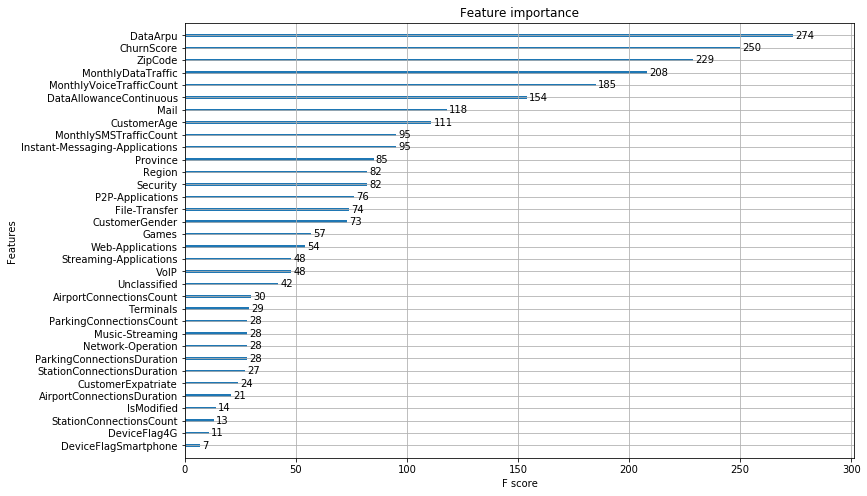

Feature_Importances: 
Index(['DeviceFlag4G', 'ZipCode', 'CustomerExpatriate',
       'MonthlySMSTrafficCount', 'DeviceFlagSmartphone', 'DataArpu',
       'Instant-Messaging-Applications', 'IsModified', 'Games',
       'MonthlyVoiceTrafficCount'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': 1, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 1, 'num_class': 4}
n_estimator: 100


100

In [13]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb0 = XGBClassifier(
        objective='multi:softmax',
        num_class=4)
# print(train[predictors].values)
modelfit(xgb0, train, predictors)

In [10]:
xgb0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [11]:
learning_rate = 0.1
n_estimators = 1000
max_depth = 5
min_child_weight = 1
gamma = 0
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 0.005
cv = 5

[0]	train-merror:0.382591+0.00210539	train-mlogloss:1.32788+0.000746294	test-merror:0.411204+0.00568557	test-mlogloss:1.33264+0.000746945
[1]	train-merror:0.375901+0.00201276	train-mlogloss:1.27892+0.00144785	test-merror:0.410577+0.00815969	test-mlogloss:1.28897+0.00145192
[2]	train-merror:0.372034+0.00268018	train-mlogloss:1.23673+0.00182287	test-merror:0.407965+0.00761111	test-mlogloss:1.25156+0.00162372
[3]	train-merror:0.369656+0.00391258	train-mlogloss:1.19988+0.00212576	test-merror:0.408592+0.00784847	test-mlogloss:1.21967+0.0018991
[4]	train-merror:0.367069+0.0040166	train-mlogloss:1.16799+0.00246387	test-merror:0.408487+0.00672414	test-mlogloss:1.19221+0.00211822
[5]	train-merror:0.365893+0.0039996	train-mlogloss:1.1399+0.00280346	test-merror:0.408382+0.00598543	test-mlogloss:1.16861+0.00308144
[6]	train-merror:0.364142+0.0038974	train-mlogloss:1.11493+0.00281077	test-merror:0.40765+0.0064684	test-mlogloss:1.14779+0.00338745
[7]	train-merror:0.360954+0.00397051	train-mlogloss:1

[60]	train-merror:0.275243+0.00254959	train-mlogloss:0.772615+0.00440693	test-merror:0.399916+0.00687296	test-mlogloss:0.98451+0.0138766
[61]	train-merror:0.274433+0.00303786	train-mlogloss:0.769832+0.00450952	test-merror:0.399603+0.00736676	test-mlogloss:0.984249+0.0138919
[62]	train-merror:0.273179+0.00270519	train-mlogloss:0.767413+0.00418844	test-merror:0.399498+0.00739836	test-mlogloss:0.984019+0.0141823
[63]	train-merror:0.272134+0.00259968	train-mlogloss:0.764918+0.00425253	test-merror:0.399394+0.00861861	test-mlogloss:0.984109+0.0140133
[64]	train-merror:0.270958+0.00266039	train-mlogloss:0.762365+0.00394667	test-merror:0.399185+0.00820315	test-mlogloss:0.984286+0.0140022
[65]	train-merror:0.269129+0.00279293	train-mlogloss:0.759764+0.00397655	test-merror:0.398767+0.00905472	test-mlogloss:0.984262+0.0139562
[66]	train-merror:0.267299+0.00323922	train-mlogloss:0.757052+0.00422934	test-merror:0.398767+0.00808712	test-mlogloss:0.984086+0.0138349
[67]	train-merror:0.26581+0.0028016

[120]	train-merror:0.208373+0.00355214	train-mlogloss:0.643292+0.00413228	test-merror:0.398349+0.0101921	test-mlogloss:0.986618+0.0138751
[121]	train-merror:0.207563+0.00352194	train-mlogloss:0.641609+0.00406447	test-merror:0.398767+0.0099032	test-mlogloss:0.986717+0.0138914
[122]	train-merror:0.206204+0.00407123	train-mlogloss:0.63979+0.0041741	test-merror:0.398976+0.00960199	test-mlogloss:0.986747+0.0140899
[123]	train-merror:0.205237+0.00305764	train-mlogloss:0.63761+0.00391147	test-merror:0.398976+0.0108047	test-mlogloss:0.986823+0.0141673
[124]	train-merror:0.204375+0.00307735	train-mlogloss:0.635856+0.00384874	test-merror:0.399603+0.010782	test-mlogloss:0.986808+0.0142004
(76, 8)

Model Report
Accuracy : 0.7248
f1_micro : 0.7248
f1_macro : 0.5893
f1_weighted : 0.6922


C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


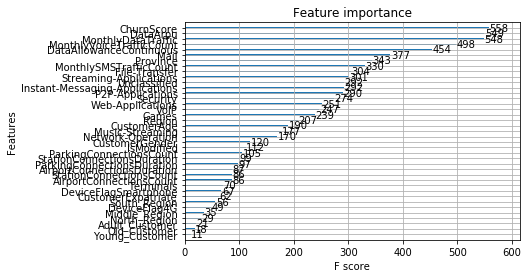

Feature_Importances: 
Index(['CustomerExpatriate', 'DeviceFlag4G', 'MonthlySMSTrafficCount',
       'DeviceFlagSmartphone', 'DataArpu', 'Instant-Messaging-Applications',
       'Region', 'MonthlyVoiceTrafficCount', 'ParkingConnectionsCount',
       'Security'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 76, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.8, 'num_class': 4}
n_estimator: 76


In [12]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softprob',
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb1, train, predictors)

In [13]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample,
                                        colsample_bytree=colsample_bytree, objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=cv,verbose=1)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   53.4s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  1.5min finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58921, std: 0.01180, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.58806, std: 0.00982, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.59047, std: 0.00859, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.58733, std: 0.01692, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.58660, std: 0.01477, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.58994, std: 0.01246, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.58399, std: 0.01001, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.58629, std: 0.01528, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.58880, std: 0.01191, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.58921, std: 0.01124, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.58608, std: 0.01196, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.58587, std: 0.01287, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 5

In [14]:
max_depth = gsearch1.best_params_['max_depth']
min_child_weight = gsearch1.best_params_['min_child_weight']
max_depth,min_child_weight

(3, 5)

In [15]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[max_depth-1,max_depth,max_depth+1],
    'min_child_weight':[min_child_weight-1,min_child_weight,min_child_weight+1]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   35.7s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58420, std: 0.00271, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.58493, std: 0.00281, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.58346, std: 0.00302, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.59130, std: 0.00830, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.59047, std: 0.00859, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.59005, std: 0.00777, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.58900, std: 0.01278, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.59036, std: 0.01321, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.58806, std: 0.01345, params: {'max_depth': 4, 'min_child_weight': 6}],
 {'max_depth': 3, 'min_child_weight': 4},
 0.591303531588493)

In [16]:
max_depth = gsearch2.best_params_['max_depth']
min_child_weight = gsearch2.best_params_['min_child_weight']
max_depth,min_child_weight

(3, 4)

In [17]:
#Grid seach on subsample and max_features#Grid se 
#Choose all predictors except target & IDcols
param_test2b = {
    'min_child_weight':[min_child_weight,min_child_weight+2,min_child_weight+4,min_child_weight+6]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   16.6s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.59130, std: 0.00830, params: {'min_child_weight': 4},
  mean: 0.59005, std: 0.00777, params: {'min_child_weight': 6},
  mean: 0.59109, std: 0.00812, params: {'min_child_weight': 8},
  mean: 0.59026, std: 0.00840, params: {'min_child_weight': 10}],
 {'min_child_weight': 4},
 0.591303531588493)

In [18]:
min_child_weight = gsearch2b.best_params_['min_child_weight']
min_child_weight

4

In [19]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   20.8s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.59130, std: 0.00830, params: {'gamma': 0.0},
  mean: 0.59172, std: 0.00805, params: {'gamma': 0.1},
  mean: 0.59172, std: 0.00797, params: {'gamma': 0.2},
  mean: 0.59183, std: 0.00780, params: {'gamma': 0.3},
  mean: 0.59151, std: 0.00788, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 0.5918260522508916)

In [20]:
gamma = gsearch3.best_params_['gamma']
gamma

0.3

[0]	train-merror:0.406789+0.0028949	train-mlogloss:1.33532+0.0003731	test-merror:0.413608+0.0108842	test-mlogloss:1.33641+0.000811606
[1]	train-merror:0.409402+0.00409188	train-mlogloss:1.29299+0.001219	test-merror:0.414757+0.0101253	test-mlogloss:1.29551+0.00166363
[2]	train-merror:0.404908+0.00262087	train-mlogloss:1.25652+0.0014684	test-merror:0.411204+0.00847472	test-mlogloss:1.2603+0.00159781
[3]	train-merror:0.405195+0.0054055	train-mlogloss:1.2255+0.00174797	test-merror:0.412981+0.00918022	test-mlogloss:1.23063+0.0020532
[4]	train-merror:0.404646+0.00387198	train-mlogloss:1.19852+0.00205903	test-merror:0.411831+0.00809475	test-mlogloss:1.20502+0.00222448
[5]	train-merror:0.405012+0.00397128	train-mlogloss:1.17544+0.00240896	test-merror:0.412772+0.00770101	test-mlogloss:1.18296+0.00267198
[6]	train-merror:0.404751+0.00282965	train-mlogloss:1.15494+0.00236675	test-merror:0.416117+0.00907422	test-mlogloss:1.1637+0.00339134
[7]	train-merror:0.40496+0.00377541	train-mlogloss:1.13724+

[61]	train-merror:0.368611+0.00287008	train-mlogloss:0.931554+0.00399252	test-merror:0.405456+0.00777677	test-mlogloss:0.99857+0.0101746
[62]	train-merror:0.367931+0.00294088	train-mlogloss:0.930342+0.0039356	test-merror:0.406397+0.00761112	test-mlogloss:0.998287+0.0103507
[63]	train-merror:0.367174+0.00310339	train-mlogloss:0.929036+0.00389075	test-merror:0.405874+0.00758084	test-mlogloss:0.997821+0.010547
[64]	train-merror:0.366651+0.00279164	train-mlogloss:0.927769+0.00389555	test-merror:0.40556+0.00822498	test-mlogloss:0.997523+0.0106119
[65]	train-merror:0.365841+0.00277414	train-mlogloss:0.926552+0.00387446	test-merror:0.406396+0.00847394	test-mlogloss:0.997201+0.0106679
[66]	train-merror:0.365475+0.00248663	train-mlogloss:0.925267+0.00396837	test-merror:0.405874+0.0069428	test-mlogloss:0.996789+0.0107363
[67]	train-merror:0.364691+0.00244463	train-mlogloss:0.923973+0.004001	test-merror:0.40671+0.00705752	test-mlogloss:0.996395+0.010713
[68]	train-merror:0.364143+0.00233408	train

[121]	train-merror:0.334666+0.00169095	train-mlogloss:0.869488+0.00421386	test-merror:0.402111+0.00696939	test-mlogloss:0.987945+0.0113576
[122]	train-merror:0.334274+0.00159985	train-mlogloss:0.868696+0.00421488	test-merror:0.402215+0.00674413	test-mlogloss:0.98799+0.011477
[123]	train-merror:0.333412+0.00111046	train-mlogloss:0.867722+0.00420506	test-merror:0.402529+0.00806295	test-mlogloss:0.987823+0.0114789
[124]	train-merror:0.332889+0.00115964	train-mlogloss:0.866921+0.00421927	test-merror:0.402738+0.00829111	test-mlogloss:0.987829+0.0114048
[125]	train-merror:0.332732+0.00122571	train-mlogloss:0.866118+0.0041216	test-merror:0.40253+0.00780422	test-mlogloss:0.987833+0.0115594
[126]	train-merror:0.332288+0.0011271	train-mlogloss:0.865373+0.00411788	test-merror:0.402947+0.00773554	test-mlogloss:0.987871+0.0116016
[127]	train-merror:0.332393+0.00112226	train-mlogloss:0.864577+0.00413863	test-merror:0.402947+0.00800748	test-mlogloss:0.988033+0.0116585
[128]	train-merror:0.331792+0.00

[181]	train-merror:0.310521+0.00227766	train-mlogloss:0.823443+0.00367086	test-merror:0.401693+0.00850672	test-mlogloss:0.987197+0.0119746
[182]	train-merror:0.310495+0.00205081	train-mlogloss:0.82264+0.00367981	test-merror:0.402634+0.00798779	test-mlogloss:0.987175+0.0119682
[183]	train-merror:0.309763+0.00213353	train-mlogloss:0.822067+0.00356023	test-merror:0.402634+0.00768393	test-mlogloss:0.987358+0.0118541
[184]	train-merror:0.309292+0.0026841	train-mlogloss:0.821286+0.00348434	test-merror:0.402425+0.00741227	test-mlogloss:0.987273+0.0118569
[185]	train-merror:0.308926+0.00255252	train-mlogloss:0.820648+0.00356038	test-merror:0.402529+0.00754201	test-mlogloss:0.987328+0.0119112
[186]	train-merror:0.308613+0.00255105	train-mlogloss:0.82+0.00354256	test-merror:0.402634+0.00725069	test-mlogloss:0.987426+0.0119105
[187]	train-merror:0.307986+0.00271535	train-mlogloss:0.819238+0.00352733	test-merror:0.402947+0.00680988	test-mlogloss:0.987424+0.011976
[188]	train-merror:0.307751+0.0027

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6748
f1_micro : 0.6748
f1_macro : 0.4946
f1_weighted : 0.6303


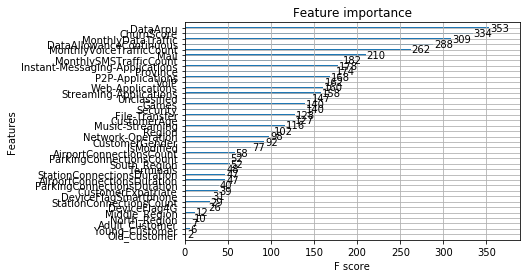

Feature_Importances: 
Index(['DeviceFlag4G', 'CustomerExpatriate', 'MonthlySMSTrafficCount',
       'DataArpu', 'DeviceFlagSmartphone', 'Instant-Messaging-Applications',
       'MonthlyVoiceTrafficCount', 'Games', 'Region', 'Network-Operation'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 4, 'missing': None, 'n_estimators': 176, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.8, 'num_class': 4}
n_estimator: 176


In [21]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =learning_rate,
        n_estimators=1000,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb2, train, predictors)

# Tune subsample and colsample_bytree

In [22]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  2.2min finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.57772, std: 0.01327, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.57270, std: 0.02008, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.57751, std: 0.01479, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.57280, std: 0.02890, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.57834, std: 0.01327, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.57500, std: 0.01478, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.57249, std: 0.02148, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.57395, std: 0.02035, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.57970, std: 0.01311, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.57500, std: 0.01821, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.57636, std: 0.01682, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.57312, std: 0.02507, params: {'colsample_bytree': 0.8, 'subsample'

In [23]:
subsample = gsearch4.best_params_['subsample']
colsample_bytree = gsearch4.best_params_['colsample_bytree']
subsample,colsample_bytree

(0.6, 0.8)

In [24]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(int(subsample*100-5),int(subsample*100+5),5)],
    'colsample_bytree':[i/100.0 for i in range(int(colsample_bytree*100-5),int(colsample_bytree*100+5),5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   33.5s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58075, std: 0.01096, params: {'colsample_bytree': 0.75, 'subsample': 0.55},
  mean: 0.57928, std: 0.01149, params: {'colsample_bytree': 0.75, 'subsample': 0.6},
  mean: 0.58002, std: 0.01209, params: {'colsample_bytree': 0.8, 'subsample': 0.55},
  mean: 0.57970, std: 0.01311, params: {'colsample_bytree': 0.8, 'subsample': 0.6}],
 {'colsample_bytree': 0.75, 'subsample': 0.55},
 0.5807481884938747)

In [25]:
subsample = gsearch5.best_params_['subsample']
colsample_bytree = gsearch5.best_params_['colsample_bytree']
subsample,colsample_bytree

(0.55, 0.75)

# regularization:

In [26]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='f1_micro',n_jobs=4,iid=False, cv=cv, verbose=1)
gsearch6.fit(train[predictors],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   41.1s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58075, std: 0.01096, params: {'reg_alpha': 1e-05},
  mean: 0.57897, std: 0.01125, params: {'reg_alpha': 0.01},
  mean: 0.57866, std: 0.01233, params: {'reg_alpha': 0.1},
  mean: 0.58242, std: 0.01047, params: {'reg_alpha': 1},
  mean: 0.56580, std: 0.00200, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.5824194787427901)

In [27]:
reg_alpha = gsearch6.best_params_['reg_alpha']
reg_alpha

1

In [28]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='f1_micro',n_jobs=4,iid=False, cv=cv,verbose=1)
gsearch7.fit(train[predictors],train[target])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   40.2s finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.58075, std: 0.01096, params: {'reg_alpha': 0},
  mean: 0.57970, std: 0.01114, params: {'reg_alpha': 0.001},
  mean: 0.57719, std: 0.01185, params: {'reg_alpha': 0.005},
  mean: 0.57897, std: 0.01125, params: {'reg_alpha': 0.01},
  mean: 0.57981, std: 0.01056, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0},
 0.5807481884938747)

In [29]:
reg_alpha = gsearch7.best_params_['reg_alpha']
reg_alpha

0

[0]	train-merror:0.412825+0.0033363	train-mlogloss:1.33624+0.000725232	test-merror:0.418314+0.00746241	test-mlogloss:1.33742+0.0012314
[1]	train-merror:0.416144+0.00650785	train-mlogloss:1.29471+0.00149626	test-merror:0.420195+0.00617704	test-mlogloss:1.29722+0.00114192
[2]	train-merror:0.412276+0.00523398	train-mlogloss:1.25839+0.00164723	test-merror:0.421553+0.00606048	test-mlogloss:1.26244+0.00120178
[3]	train-merror:0.410552+0.00547755	train-mlogloss:1.22777+0.00179055	test-merror:0.419671+0.00680457	test-mlogloss:1.23261+0.00159413
[4]	train-merror:0.412381+0.00318733	train-mlogloss:1.20178+0.00127039	test-merror:0.422389+0.00802013	test-mlogloss:1.20784+0.00257966
[5]	train-merror:0.410787+0.00344357	train-mlogloss:1.17849+0.00172962	test-merror:0.42124+0.0094845	test-mlogloss:1.18535+0.00257381
[6]	train-merror:0.40969+0.00281964	train-mlogloss:1.15795+0.00138783	test-merror:0.41894+0.00919702	test-mlogloss:1.16598+0.00373577
[7]	train-merror:0.411022+0.00318975	train-mlogloss:1

[61]	train-merror:0.369734+0.00239509	train-mlogloss:0.932694+0.00378784	test-merror:0.40368+0.00797388	test-mlogloss:0.997681+0.0112304
[62]	train-merror:0.368951+0.00227	train-mlogloss:0.931425+0.00381976	test-merror:0.403157+0.00758532	test-mlogloss:0.997447+0.0111298
[63]	train-merror:0.36848+0.00208837	train-mlogloss:0.930213+0.00383134	test-merror:0.403261+0.00737135	test-mlogloss:0.996965+0.0110487
[64]	train-merror:0.367252+0.00297519	train-mlogloss:0.929033+0.00380887	test-merror:0.403889+0.00733413	test-mlogloss:0.996724+0.0111303
[65]	train-merror:0.366155+0.00304413	train-mlogloss:0.927734+0.00396605	test-merror:0.403366+0.00682645	test-mlogloss:0.99647+0.0112019
[66]	train-merror:0.365737+0.00268207	train-mlogloss:0.926414+0.00387447	test-merror:0.403366+0.00693407	test-mlogloss:0.996003+0.011298
[67]	train-merror:0.365109+0.00259395	train-mlogloss:0.925204+0.00389224	test-merror:0.403366+0.0065364	test-mlogloss:0.995627+0.0114694
[68]	train-merror:0.364404+0.00281125	trai

[121]	train-merror:0.335215+0.00256228	train-mlogloss:0.87083+0.00465231	test-merror:0.401171+0.00733451	test-mlogloss:0.987198+0.0118038
[122]	train-merror:0.33477+0.00243361	train-mlogloss:0.869986+0.00466148	test-merror:0.401066+0.00691761	test-mlogloss:0.987006+0.0118865
[123]	train-merror:0.3343+0.00204872	train-mlogloss:0.869052+0.00465151	test-merror:0.401066+0.0075099	test-mlogloss:0.986971+0.0119477
[124]	train-merror:0.334405+0.00254859	train-mlogloss:0.868161+0.00468945	test-merror:0.400439+0.00756852	test-mlogloss:0.986887+0.0119355
[125]	train-merror:0.333699+0.00198167	train-mlogloss:0.867245+0.00476023	test-merror:0.40117+0.00748024	test-mlogloss:0.986893+0.0120348
[126]	train-merror:0.33315+0.00240583	train-mlogloss:0.866475+0.00476059	test-merror:0.400962+0.00731254	test-mlogloss:0.986977+0.0119164
[127]	train-merror:0.33221+0.00286323	train-mlogloss:0.86569+0.00481228	test-merror:0.401484+0.00705854	test-mlogloss:0.987118+0.0117558
[128]	train-merror:0.331243+0.003324

[181]	train-merror:0.312637+0.00186505	train-mlogloss:0.824218+0.00446323	test-merror:0.401275+0.00609359	test-mlogloss:0.986008+0.0125991
[182]	train-merror:0.312062+0.00196468	train-mlogloss:0.823576+0.0045161	test-merror:0.401798+0.00687863	test-mlogloss:0.986143+0.0126446
[183]	train-merror:0.311461+0.00195975	train-mlogloss:0.822867+0.00444587	test-merror:0.402321+0.00715911	test-mlogloss:0.986451+0.0126934
[184]	train-merror:0.310782+0.00141336	train-mlogloss:0.822169+0.00446517	test-merror:0.402425+0.0079213	test-mlogloss:0.986443+0.0125921
[185]	train-merror:0.31005+0.00149197	train-mlogloss:0.821423+0.00437682	test-merror:0.401484+0.00761698	test-mlogloss:0.986238+0.0128467
[186]	train-merror:0.310102+0.0010494	train-mlogloss:0.820642+0.00437632	test-merror:0.400752+0.0078698	test-mlogloss:0.986327+0.0129918
[187]	train-merror:0.310102+0.00130319	train-mlogloss:0.819947+0.0044408	test-merror:0.401484+0.00725805	test-mlogloss:0.986462+0.0128858
[188]	train-merror:0.309397+0.001

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6703
f1_micro : 0.6703
f1_macro : 0.4866
f1_weighted : 0.6252


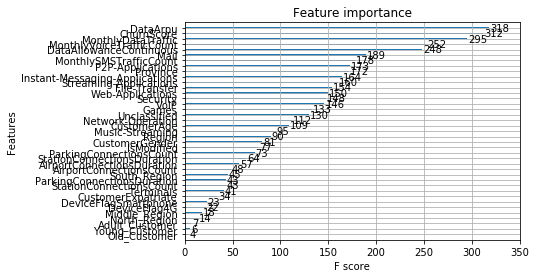

Feature_Importances: 
Index(['DeviceFlag4G', 'CustomerExpatriate', 'MonthlySMSTrafficCount',
       'DeviceFlagSmartphone', 'DataArpu', 'Instant-Messaging-Applications',
       'MonthlyVoiceTrafficCount', 'Network-Operation', 'Region', 'Games'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.75, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 4, 'missing': None, 'n_estimators': 169, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.55, 'num_class': 4}
n_estimator: 169


In [30]:
xgb3 = XGBClassifier(
        learning_rate =learning_rate,
        n_estimators=1000,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb3, train, predictors)

[0]	train-merror:0.412825+0.0033363	train-mlogloss:1.33624+0.000725232	test-merror:0.418314+0.00746241	test-mlogloss:1.33742+0.0012314
[1]	train-merror:0.416144+0.00650785	train-mlogloss:1.29471+0.00149626	test-merror:0.420195+0.00617704	test-mlogloss:1.29722+0.00114192
[2]	train-merror:0.412276+0.00523398	train-mlogloss:1.25839+0.00164723	test-merror:0.421553+0.00606048	test-mlogloss:1.26244+0.00120178
[3]	train-merror:0.410552+0.00547755	train-mlogloss:1.22777+0.00179055	test-merror:0.419671+0.00680457	test-mlogloss:1.23261+0.00159413
[4]	train-merror:0.412381+0.00318733	train-mlogloss:1.20178+0.00127039	test-merror:0.422389+0.00802013	test-mlogloss:1.20784+0.00257966
[5]	train-merror:0.410787+0.00344357	train-mlogloss:1.17849+0.00172962	test-merror:0.42124+0.0094845	test-mlogloss:1.18535+0.00257381
[6]	train-merror:0.40969+0.00281964	train-mlogloss:1.15795+0.00138783	test-merror:0.41894+0.00919702	test-mlogloss:1.16598+0.00373577
[7]	train-merror:0.411022+0.00318975	train-mlogloss:1

[61]	train-merror:0.369734+0.00239509	train-mlogloss:0.932694+0.00378784	test-merror:0.40368+0.00797388	test-mlogloss:0.997681+0.0112304
[62]	train-merror:0.368951+0.00227	train-mlogloss:0.931425+0.00381976	test-merror:0.403157+0.00758532	test-mlogloss:0.997447+0.0111298
[63]	train-merror:0.36848+0.00208837	train-mlogloss:0.930213+0.00383134	test-merror:0.403261+0.00737135	test-mlogloss:0.996965+0.0110487
[64]	train-merror:0.367252+0.00297519	train-mlogloss:0.929033+0.00380887	test-merror:0.403889+0.00733413	test-mlogloss:0.996724+0.0111303
[65]	train-merror:0.366155+0.00304413	train-mlogloss:0.927734+0.00396605	test-merror:0.403366+0.00682645	test-mlogloss:0.99647+0.0112019
[66]	train-merror:0.365737+0.00268207	train-mlogloss:0.926414+0.00387447	test-merror:0.403366+0.00693407	test-mlogloss:0.996003+0.011298
[67]	train-merror:0.365109+0.00259395	train-mlogloss:0.925204+0.00389224	test-merror:0.403366+0.0065364	test-mlogloss:0.995627+0.0114694
[68]	train-merror:0.364404+0.00281125	trai

[121]	train-merror:0.335215+0.00256228	train-mlogloss:0.87083+0.00465231	test-merror:0.401171+0.00733451	test-mlogloss:0.987198+0.0118038
[122]	train-merror:0.33477+0.00243361	train-mlogloss:0.869986+0.00466148	test-merror:0.401066+0.00691761	test-mlogloss:0.987006+0.0118865
[123]	train-merror:0.3343+0.00204872	train-mlogloss:0.869052+0.00465151	test-merror:0.401066+0.0075099	test-mlogloss:0.986971+0.0119477
[124]	train-merror:0.334405+0.00254859	train-mlogloss:0.868161+0.00468945	test-merror:0.400439+0.00756852	test-mlogloss:0.986887+0.0119355
[125]	train-merror:0.333699+0.00198167	train-mlogloss:0.867245+0.00476023	test-merror:0.40117+0.00748024	test-mlogloss:0.986893+0.0120348
[126]	train-merror:0.33315+0.00240583	train-mlogloss:0.866475+0.00476059	test-merror:0.400962+0.00731254	test-mlogloss:0.986977+0.0119164
[127]	train-merror:0.33221+0.00286323	train-mlogloss:0.86569+0.00481228	test-merror:0.401484+0.00705854	test-mlogloss:0.987118+0.0117558
[128]	train-merror:0.331243+0.003324

[181]	train-merror:0.312637+0.00186505	train-mlogloss:0.824218+0.00446323	test-merror:0.401275+0.00609359	test-mlogloss:0.986008+0.0125991
[182]	train-merror:0.312062+0.00196468	train-mlogloss:0.823576+0.0045161	test-merror:0.401798+0.00687863	test-mlogloss:0.986143+0.0126446
[183]	train-merror:0.311461+0.00195975	train-mlogloss:0.822867+0.00444587	test-merror:0.402321+0.00715911	test-mlogloss:0.986451+0.0126934
[184]	train-merror:0.310782+0.00141336	train-mlogloss:0.822169+0.00446517	test-merror:0.402425+0.0079213	test-mlogloss:0.986443+0.0125921
[185]	train-merror:0.31005+0.00149197	train-mlogloss:0.821423+0.00437682	test-merror:0.401484+0.00761698	test-mlogloss:0.986238+0.0128467
[186]	train-merror:0.310102+0.0010494	train-mlogloss:0.820642+0.00437632	test-merror:0.400752+0.0078698	test-mlogloss:0.986327+0.0129918
[187]	train-merror:0.310102+0.00130319	train-mlogloss:0.819947+0.0044408	test-merror:0.401484+0.00725805	test-mlogloss:0.986462+0.0128858
[188]	train-merror:0.309397+0.001

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6865
f1_micro : 0.6865
f1_macro : 0.5193
f1_weighted : 0.6471


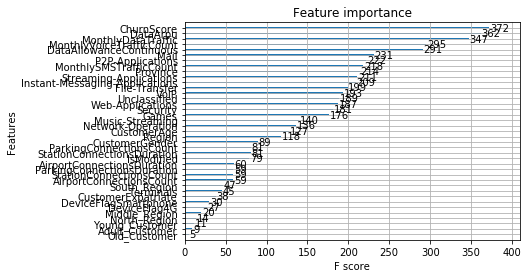

Feature_Importances: 
Index(['CustomerExpatriate', 'DeviceFlag4G', 'MonthlySMSTrafficCount',
       'DeviceFlagSmartphone', 'DataArpu', 'Instant-Messaging-Applications',
       'Network-Operation', 'MonthlyVoiceTrafficCount', 'Region', 'Security'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.75, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 4, 'missing': None, 'n_estimators': 209, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.55, 'num_class': 4}
n_estimator: 209


In [31]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=209,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb4, train, predictors)

In [32]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test8 = {
    #learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators' : [50, 100, 150, 200, 300]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =learning_rate, n_estimators=n_estimators, max_depth=max_depth,
                                        min_child_weight=min_child_weight, gamma=gamma, subsample=subsample, colsample_bytree=colsample_bytree,
                                        objective='multi:softprob', num_class=4, nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test8, scoring='f1_micro',n_jobs=4,iid=False, cv=cv,verbose=1)
gsearch8.fit(train[predictors],train[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   54.6s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  3.4min finished
C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.57960, std: 0.00340, params: {'learning_rate': 0.0001, 'n_estimators': 50},
  mean: 0.57970, std: 0.00391, params: {'learning_rate': 0.0001, 'n_estimators': 100},
  mean: 0.58263, std: 0.00218, params: {'learning_rate': 0.0001, 'n_estimators': 150},
  mean: 0.58252, std: 0.00224, params: {'learning_rate': 0.0001, 'n_estimators': 200},
  mean: 0.57991, std: 0.00273, params: {'learning_rate': 0.0001, 'n_estimators': 300},
  mean: 0.57949, std: 0.00412, params: {'learning_rate': 0.001, 'n_estimators': 50},
  mean: 0.58001, std: 0.00413, params: {'learning_rate': 0.001, 'n_estimators': 100},
  mean: 0.58294, std: 0.00313, params: {'learning_rate': 0.001, 'n_estimators': 150},
  mean: 0.58127, std: 0.00299, params: {'learning_rate': 0.001, 'n_estimators': 200},
  mean: 0.58169, std: 0.00405, params: {'learning_rate': 0.001, 'n_estimators': 300},
  mean: 0.58085, std: 0.00249, params: {'learning_rate': 0.01, 'n_estimators': 50},
  mean: 0.58263, std: 0.00358, params: {'learning_rat

In [33]:
train.columns

Index(['ID', 'DeviceFlag4G', 'DataArpu', 'DataAllowanceContinuous',
       'DeviceFlagSmartphone', 'MonthlyVoiceTrafficCount',
       'MonthlySMSTrafficCount', 'MonthlyDataTraffic', 'CustomerGender',
       'CustomerExpatriate', 'ChurnScore', 'AirportConnectionsDuration',
       'AirportConnectionsCount', 'StationConnectionsDuration',
       'StationConnectionsCount', 'ParkingConnectionsDuration',
       'ParkingConnectionsCount', 'File-Transfer', 'Games',
       'Instant-Messaging-Applications', 'Mail', 'Music-Streaming',
       'Network-Operation', 'P2P-Applications', 'Security',
       'Streaming-Applications', 'Terminals', 'Unclassified', 'VoIP',
       'Web-Applications', 'IsModified', 'CustomerAge', 'Region', 'Province',
       'Product', 'North_Region', 'Middle_Region', 'South_Region',
       'Young_Customer', 'Adult_Customer', 'Old_Customer'],
      dtype='object')

In [34]:
train[predictors].shape,train[target].shape,test[predictors].shape

((9567, 39), (9567,), (3190, 39))

In [51]:
pred = ['MonthlySMSTrafficCount', 'CustomerExpatriate', 'DeviceFlag4G',
       'DeviceFlagSmartphone', 'DataArpu', 'Instant-Messaging-Applications',
       'Region', 'Unclassified', 'Games', 'Security']
train[pred].head()

,MonthlySMSTrafficCount,CustomerExpatriate,DeviceFlag4G,DeviceFlagSmartphone,DataArpu,Instant-Messaging-Applications,Region,Unclassified,Games,Security
0,0.000125,0.0,1.0,1.0,0.310172,0.039575,0.0,0.001460,0.000200,0.000440
1,0.004370,0.0,1.0,1.0,0.232629,0.005714,0.0,0.000118,0.000005,0.000007
2,0.009613,0.0,1.0,1.0,0.155086,0.122763,0.0,0.009732,0.000843,0.000497
3,0.007116,0.0,0.0,1.0,0.155086,0.001753,0.0,0.003864,0.000036,0.000021
4,0.004245,0.0,0.0,1.0,0.387526,0.098735,0.0,0.001569,0.000453,0.047630


[0]	train-merror:0.412773+0.00365387	train-mlogloss:1.33651+0.000677182	test-merror:0.416014+0.00485425	test-mlogloss:1.33764+0.00115048
[1]	train-merror:0.416013+0.00510233	train-mlogloss:1.29517+0.00148232	test-merror:0.419568+0.00640881	test-mlogloss:1.29764+0.00101626
[2]	train-merror:0.411832+0.00439761	train-mlogloss:1.25909+0.00156634	test-merror:0.420926+0.0073046	test-mlogloss:1.26305+0.00116572
[3]	train-merror:0.410369+0.00574152	train-mlogloss:1.22834+0.00139476	test-merror:0.420508+0.00585257	test-mlogloss:1.23324+0.00156226
[4]	train-merror:0.412067+0.00426775	train-mlogloss:1.20252+0.00107282	test-merror:0.421135+0.00823223	test-mlogloss:1.20856+0.00268745
[5]	train-merror:0.410839+0.0041436	train-mlogloss:1.17934+0.00159175	test-merror:0.420194+0.00897478	test-mlogloss:1.18617+0.00260366
[6]	train-merror:0.410421+0.00340085	train-mlogloss:1.15884+0.00132826	test-merror:0.420299+0.00974978	test-mlogloss:1.16671+0.00340731
[7]	train-merror:0.411336+0.00311945	train-mloglo

[61]	train-merror:0.371903+0.00237657	train-mlogloss:0.936156+0.00305224	test-merror:0.405665+0.00650195	test-mlogloss:0.997089+0.0126639
[62]	train-merror:0.371067+0.0025219	train-mlogloss:0.934933+0.00306323	test-merror:0.40577+0.00630711	test-mlogloss:0.99685+0.0125642
[63]	train-merror:0.370701+0.00271461	train-mlogloss:0.933737+0.00311248	test-merror:0.404307+0.00611902	test-mlogloss:0.996363+0.0124851
[64]	train-merror:0.369682+0.00277889	train-mlogloss:0.932539+0.00312817	test-merror:0.404097+0.00678955	test-mlogloss:0.996178+0.0125302
[65]	train-merror:0.369107+0.00315409	train-mlogloss:0.931281+0.00324154	test-merror:0.404411+0.00691284	test-mlogloss:0.995782+0.0126576
[66]	train-merror:0.368454+0.00312946	train-mlogloss:0.930027+0.00319305	test-merror:0.405143+0.00647829	test-mlogloss:0.99534+0.0127558
[67]	train-merror:0.367958+0.00275449	train-mlogloss:0.928911+0.00321822	test-merror:0.404306+0.00709876	test-mlogloss:0.994978+0.0128143
[68]	train-merror:0.367069+0.00309929	

[121]	train-merror:0.338716+0.00265728	train-mlogloss:0.875069+0.00412057	test-merror:0.399394+0.00864441	test-mlogloss:0.984973+0.0136169
[122]	train-merror:0.338037+0.00267476	train-mlogloss:0.874248+0.00409128	test-merror:0.399917+0.00821289	test-mlogloss:0.98477+0.0136822
[123]	train-merror:0.337697+0.00243008	train-mlogloss:0.873341+0.00409059	test-merror:0.400649+0.0082651	test-mlogloss:0.984844+0.0137067
[124]	train-merror:0.337436+0.00238152	train-mlogloss:0.872441+0.00411236	test-merror:0.400649+0.00842514	test-mlogloss:0.984848+0.0135781
[125]	train-merror:0.336835+0.00237652	train-mlogloss:0.87151+0.00412681	test-merror:0.400649+0.00855776	test-mlogloss:0.984878+0.0134692
[126]	train-merror:0.336495+0.00232269	train-mlogloss:0.870735+0.00409745	test-merror:0.40044+0.00890119	test-mlogloss:0.98474+0.0134851
[127]	train-merror:0.336313+0.00258033	train-mlogloss:0.869899+0.00419682	test-merror:0.400335+0.00835948	test-mlogloss:0.984857+0.0133681
[128]	train-merror:0.335685+0.00

[181]	train-merror:0.314806+0.00183244	train-mlogloss:0.829284+0.00375484	test-merror:0.402112+0.00871945	test-mlogloss:0.983613+0.0140738
[182]	train-merror:0.314205+0.00177563	train-mlogloss:0.828606+0.00379417	test-merror:0.402426+0.00917803	test-mlogloss:0.983613+0.0141191
[183]	train-merror:0.313813+0.00197145	train-mlogloss:0.827943+0.00373599	test-merror:0.401485+0.00802894	test-mlogloss:0.98378+0.0140728
[184]	train-merror:0.313499+0.00207135	train-mlogloss:0.827225+0.00375961	test-merror:0.401694+0.00818085	test-mlogloss:0.983722+0.0139697
[185]	train-merror:0.313134+0.00209896	train-mlogloss:0.826484+0.00373628	test-merror:0.401903+0.00762855	test-mlogloss:0.98355+0.0141836
[186]	train-merror:0.31295+0.00229951	train-mlogloss:0.825763+0.00375988	test-merror:0.401694+0.00682766	test-mlogloss:0.983531+0.0141932
[187]	train-merror:0.312898+0.0020814	train-mlogloss:0.82512+0.00374882	test-merror:0.402426+0.0073024	test-mlogloss:0.983618+0.0141492
[188]	train-merror:0.312297+0.002

C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.6802
f1_micro : 0.6802
f1_macro : 0.5067
f1_weighted : 0.6389


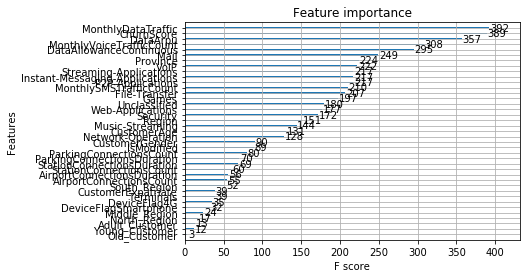

Feature_Importances: 
Index(['MonthlySMSTrafficCount', 'CustomerExpatriate', 'DeviceFlag4G',
       'DeviceFlagSmartphone', 'DataArpu', 'Instant-Messaging-Applications',
       'Region', 'Unclassified', 'Games', 'Security'],
      dtype='object')
Model: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.75, 'gamma': 0.3, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 4, 'missing': None, 'n_estimators': 209, 'nthread': 4, 'objective': 'multi:softprob', 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': 1, 'subsample': 0.55, 'num_class': 4}
n_estimator: 209


In [50]:
xgb4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=1,
        objective='multi:softprob', 
        num_class=4,
        nthread=4,
        scale_pos_weight=1,
        seed=27)
n_estimators = modelfit(xgb4, train, predictors)

In [37]:
test

,ID,DeviceFlag4G,DataArpu,DataAllowanceContinuous,DeviceFlagSmartphone,MonthlyVoiceTrafficCount,MonthlySMSTrafficCount,MonthlyDataTraffic,CustomerGender,CustomerExpatriate,...,IsModified,CustomerAge,Region,Province,North_Region,Middle_Region,South_Region,Young_Customer,Adult_Customer,Old_Customer
0,1261,1.0,0.193756,0.010692,1.0,0.007161,0.003620,0.003383,1.0,0.0,...,1,65.0,0.0,56.803073,0,1,0,0,0,1
1,5764,0.0,0.108560,0.038148,1.0,0.083984,0.000375,0.026531,1.0,0.0,...,0,55.0,0.0,42.000000,0,1,0,0,0,1
2,10617,1.0,0.000000,0.043443,1.0,0.050781,0.005119,0.009696,0.0,0.0,...,1,25.0,0.0,93.000000,0,1,0,1,0,0
3,10687,0.0,0.193756,0.000887,0.0,0.000000,0.000000,0.000000,1.0,0.0,...,1,55.0,0.0,71.000000,0,1,0,0,1,0
4,4111,1.0,0.197610,0.027273,1.0,0.072266,0.000000,0.025898,0.0,0.0,...,0,25.0,0.0,24.000000,0,1,0,0,1,0
5,12058,0.0,0.193756,0.043443,1.0,0.005859,0.000000,0.004338,1.0,0.0,...,1,35.0,0.0,24.000000,0,1,0,0,1,0
6,1346,0.0,0.108560,0.043853,1.0,0.035807,0.000125,0.021345,1.0,1.0,...,0,55.0,0.0,42.000000,0,1,0,0,1,0
7,9791,1.0,0.193756,0.043443,1.0,0.022135,0.000125,0.056230,1.0,0.0,...,1,55.0,0.0,42.000000,0,1,0,0,1,0
8,1044,1.0,0.278966,0.021568,1.0,0.064453,0.000125,0.001187,1.0,0.0,...,0,55.0,0.0,24.000000,0,1,0,0,1,0
9,2046,0.0,0.193756,0.043443,0.0,0.075614,0.003120,0.024275,0.0,0.0,...,1,55.0,0.0,42.000000,0,1,0,1,0,0


In [58]:
# X_train, X_test, y_train, y_test = train_test_split(train[predictors], train[target], test_size=0.33, random_state=7)
# eval_set = [(X_test, y_test)]
xgb4.fit(train[pred],
      train[target],
      eval_metric="merror",
      verbose=True)

y_pred_new_data = xgb4.predict(test[pred])
predictions = [round(value) for value in y_pred_new_data]

print("F1 score on unseen data: %.3f%%" % (f1_score(train[target][0:3190], y_pred_new_data[0:3190], average='micro')*100))

F1 score on unseen data: 49.154%


C:\Users\giano\Anaconda3\envs\voda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
pd.DataFrame({'Product': y_pred_new_data}).describe(),pd.DataFrame({'Product': predictions}).describe()

(           Product
 count  3190.000000
 mean      0.347649
 std       0.897971
 min       0.000000
 25%       0.000000
 50%       0.000000
 75%       0.000000
 max       3.000000,            Product
 count  3190.000000
 mean      0.347649
 std       0.897971
 min       0.000000
 25%       0.000000
 50%       0.000000
 75%       0.000000
 max       3.000000)

In [60]:
y = pd.DataFrame({'Product': y_pred_new_data})
submit = test['ID']
submit = pd.DataFrame({'ID': submit})

pred = y
pred = pd.DataFrame({'Product': y_pred_new_data})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Bag', 
    int(2) : 'V-Pet', 
    int(3) : 'V-Auto'},
    inplace=True)

submit = submit.join(product)
submit

,ID,Product
0,1261,Non-Customer
1,5764,Non-Customer
2,10617,V-Pet
3,10687,V-Auto
4,4111,Non-Customer
5,12058,Non-Customer
6,1346,Non-Customer
7,9791,Non-Customer
8,1044,Non-Customer
9,2046,V-Auto


In [61]:
submit.Product.describe()

count             3190
unique               4
top       Non-Customer
freq              2751
Name: Product, dtype: object

In [49]:
submit.to_csv('resultxgb.csv', index = False, encoding='utf-8')

In [43]:
# predictors = [x for x in train.columns if x not in [target]]
# # split data into X and y
# X = train[predictors]
# Y = train[target]
# # split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# # fit model on all training data
# model = XGBClassifier(
#         objective='multi:softprob', 
#         num_class=4)
# model.fit(X_train, y_train)
# # make predictions for test data and evaluate
# y_pred = model.predict(X_test)
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))
# # Fit model using each importance as a threshold
# thresholds = sort(model.feature_importances_)
# for thresh in thresholds:
#     # select features using threshold
#     selection = SelectFromModel(model, threshold=thresh, prefit=True)
#     select_X_train = selection.transform(X_train)
#     # train model
#     selection_model = XGBClassifier(objective='multi:softprob', 
#         num_class=4)
#     selection_model.fit(select_X_train, y_train)
#     # eval model
#     select_X_test = selection.transform(X_test)
#     y_pred = selection_model.predict(select_X_test)
#     predictions = [round(value) for value in y_pred]
#     accuracy = accuracy_score(y_test, predictions)
#     print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [44]:
# thresholds = model.feature_importances_
# thresholds

# thresholds.argsort()[-10:][::-1]
# train.columns[thresholds.argsort()[-10:][::-1]]